In [1]:
using Distributions, Statistics, LinearAlgebra, StatsPlots
pgfplotsx()

Plots.PGFPlotsXBackend()

In [13]:
mu = [ 0; 0 ]
M2 = [1 -3; -1 1];
cov = [ 1 2 ; 2 3];
c = cov * cov / 100;
d = MvNormal(mu,c);
mc_reps = 2000;
sample_size = 500;
p = 2;
q = 1;
r = p-q;
#first dimension of errors is mc_reps and second dimension is sample
errors = [M2 + rand(d,p) for _ in 1:mc_reps, _ in 1:sample_size];
#makes a mc_reps by 1 matrix of matrices
matrix_estimates = mean(errors,dims=(2));
mapslices(eigvals,matrix_estimates,dims=())

demeaned_matrices = [errors[i,:,:] .- matrix_estimates[i,:,:] for i in 1:mc_reps]

cov_estimates = Array{Float64,3}(undef,mc_reps,p^2,p^2) 
smaller_cov_estimate = Array{Float64}(undef,p,p);
smaller_cov_estimates = Array{Float64,3}(undef,mc_reps,p,p)

for mcrep in 1:mc_reps
    cov_estimate = Array{Float64,2}(undef,p^2,p^2);
    fill!(cov_estimate,0.0);
    for s in 1:sample_size
        cov_estimate += vec(demeaned_matrices[mcrep][s])*vec(demeaned_matrices[mcrep][s])';
    end
    #average across other dimension
    fill!(smaller_cov_estimate,0.0)
    for maus in 1:p
        #1 p+1 2p+1 to p 2p 
        smaller_cov_estimate += cov_estimate[(1+ (maus-1)*p) : (maus*p) , (1+ (maus-1)*p) : (maus*p) ]
    end

    cov_estimates[mcrep,:,:] = cov_estimate / sample_size;
    smaller_cov_estimates[mcrep,:,:] = smaller_cov_estimate / (p*sample_size)
end


In [3]:
smaller_cov_estimates[1,:,:]

2×2 Matrix{Float64}:
 0.0480997  0.0766088
 0.0766088  0.124153

In [4]:
cov_estimates[1,:,:]

4×4 Matrix{Float64}:
  0.0460998     0.0731133   -0.000200303  -0.0020535
  0.0731133     0.118123    -0.00224143   -0.00629288
 -0.000200303  -0.00224143   0.0500995     0.0801043
 -0.0020535    -0.00629288   0.0801043     0.130184

In [5]:
c

2×2 Matrix{Float64}:
 0.05  0.08
 0.08  0.13

In [6]:
ch = cholesky(inv(c));
ch.L * transpose(ch.L) - inv(c)

2×2 Matrix{Float64}:
  0.0          -1.13687e-13
 -1.13687e-13   0.0

Now, we have made errors, find a matrix

In [14]:
ups = eigvecs(M2)[:,1];
upsperp = Array{Float64,1}(undef,2);
upsperp[1] = ups[2];
upsperp[2] = -ups[1];
dot(ups,upsperp);
dot(upsperp,eigvecs(M2)[:,2])
function WaldStatistic(null_hyp,Mhat,OmegaW,q,samplesize)
    p = size(Mhat,1);
    r=p-q;
    #make left part of test stat
    R = eigvecs(Mhat);
    ev = eigvals(Mhat);
    L = inv(R)';
    RI = R[:,1:q];
    RJ = R[:,(q+1):p];
    LI = L[:,1:q];
    LJ = L[:,(q+1):p];
    Lambda = Diagonal(eigvals(Mhat));
    LambdaI = Lambda[1:q,1:q];
    LambdaJ = Lambda[(q+1):p,(q+1):p];
    PI = RI*LI'; #conjugate transpose
    Jacobianinv = inv(kron(transpose(LambdaI),I(r)) - kron(I(q),LambdaJ));
    BW = kron(LI,transpose(null_hyp)*RJ) * Jacobianinv * kron(transpose(RI),transpose(LJ));
    Omega = BW * kron(I(p),OmegaW) * BW';
    #C = cholesky(pinv(Omega));
    #Vp = vec(transpose(null_hyp) * PI)' * C.L;
    #result is always real but we want only real output
    return samplesize*real(vec(transpose(null_hyp) * PI)' * pinv(Omega) * vec(transpose(null_hyp) * PI));
end

WaldStatistic (generic function with 1 method)

In [8]:
waldresult = [WaldStatistic(upsperp,matrix_estimates[i],smaller_cov_estimates[i,:,:],q,sample_size) for i in 1:mc_reps];
chsq = Chisq(1);
reference = [rand(chsq) for _ in 1:mc_reps];

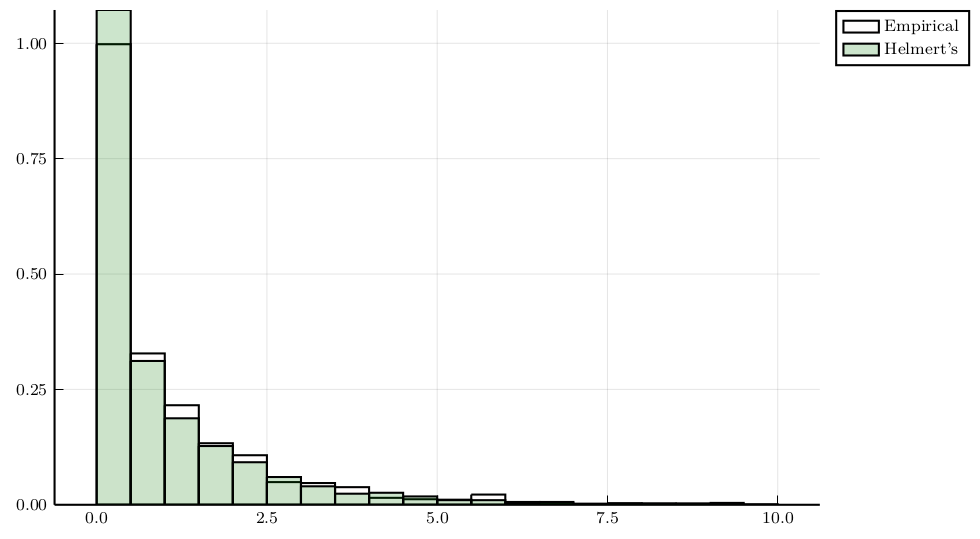

In [9]:
b_range = range(0, 10, length=21)
histogram([waldresult reference], label=["Empirical" "Helmert's"],bins=b_range,normalize = :pdf, color=[:red :green],fillalpha=[0.01 0.2])

Generate plot with density

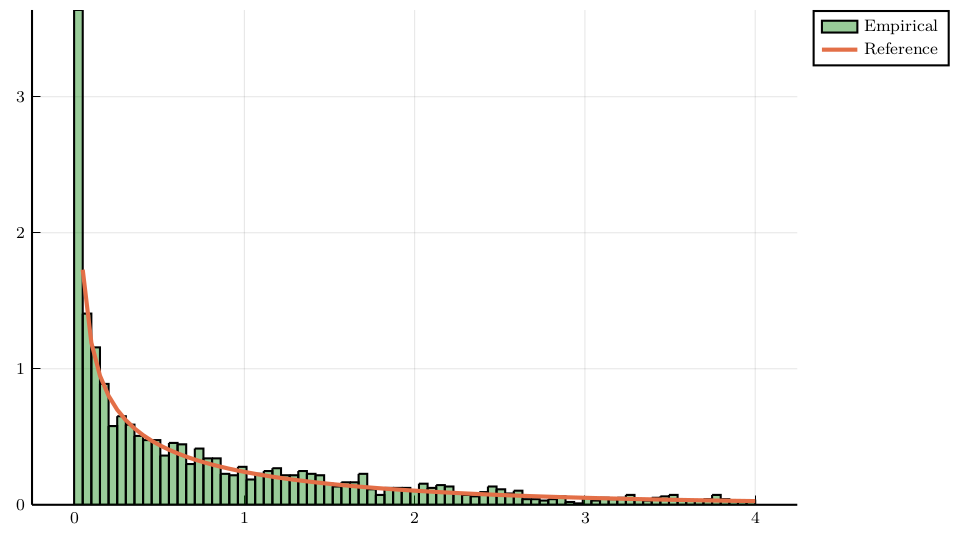

In [10]:
#import Pkg; Pkg.add("LaTeXStrings");
#using LaTeXStrings;
b_range2 = range(0, 4, length=80)
densplot=histogram(waldresult, label="Empirical",bins=b_range2,normalize = :pdf, color=:green,fillalpha=0.4)
plot!(densplot,b_range2,Chisq(1),label="Reference",lw=2) #label=L"\chi^2_{1}"
densplot

In [11]:
png(densplot,"density_wald")

"density_wald.png"

In [15]:
qui=qqplot(waldresult,Chisq(1));
savefig(qui,"qqplot2.tex")
savefig(qui,"qqplot2.pdf")
savefig(qui,"qqplot2.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/qqplot2.svg"

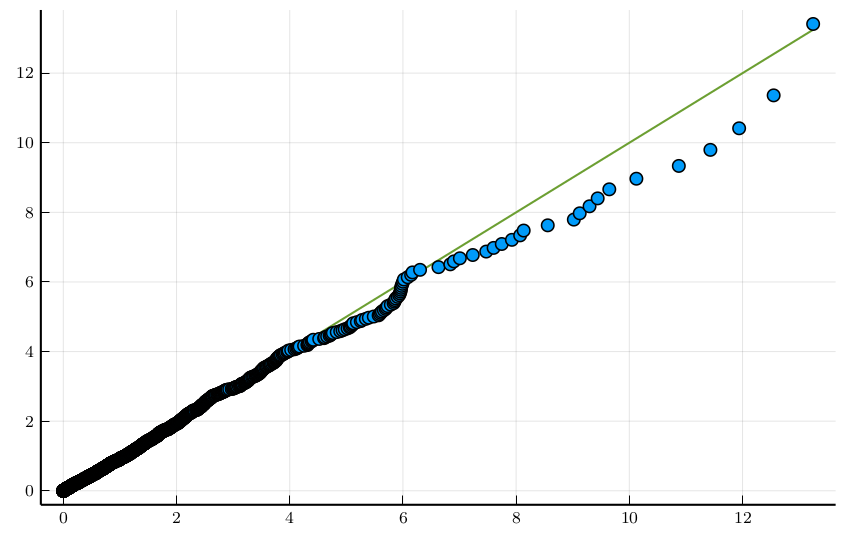

In [16]:
qui

In [14]:
#png("qqwald")

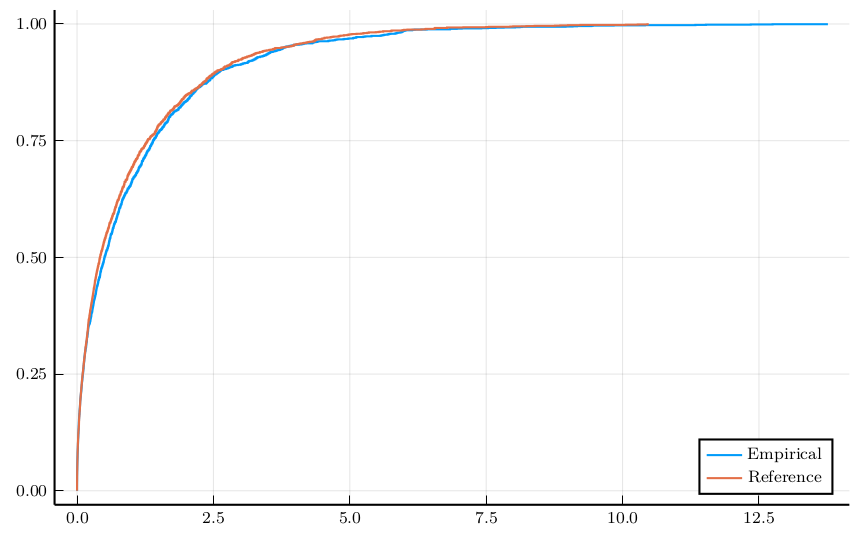

In [17]:
using StatsBase
scatter(ecdf(waldresult),label="Empirical")
scatter!(ecdf(reference),label="Reference",legend=:bottomright)

In [18]:
png("cdfwald")
savefig("cdfwald.tex")
savefig("cdfwald.pdf")
savefig("cdfwald.svg")

"/Users/jerome/Documents/resolvent-note/simulation-inference/cdfwald.svg"

Estimate size using chi squared critical values

In [17]:
rejections = waldresult .> 3.84;
mean(rejections)

0.056